In [38]:
""" Before using this program one need to run script make_memory_graph.sh
#! /bin/bash
# Build quantum graph for gathering memory usage for given collection
# set.
# Call: ./make_memory_graph.sh repo output_file list_of_collections
# repo - butler.yaml file with path like '/sdf/group/rubin/repo/dc2/butler.yaml'
# output_file - the name of quantum graph file to be created, should have gqraph
#               extension
# collections_file - a text file containing a list of space separated          
#                    collections
#like:
#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221111T202908Z
#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221113T192820Z
# example: ./make_memory_graph.sh /sdf/group/rubin/repo/dc2/butler.yaml memoryGraph.qgaph collections_file.txt
repo=$1
outfile=$2
collections_file=$3
collections=`cat $collections_file`
echo $collections
echo build-gather-resource-usage-qg $repo $outfile $collections
build-gather-resource-usage-qg $repo $outfile $collections

This will create a quantum grapf. Then one need to run script submit_graph.sh

#! /bin/bash
# Submit quantum graph with bps
# 
# Call: ./submit_graph.sh stack graph repo output_dir list_of_collections
# stack - LSST stack version like 'w_2022_50'
# grapf - a file with .qgraph extention created in make_memory_graph.sh command
# repo - base directory of the butler repo like '/sdf/group/rubin/repo/dc2'
# output_dir - the name a directory where results will be written.          
# Like  'u/kuropatk/w_2022_50/'
#       
# collections_file - a text file containing a list of space separated           
#                    collections
#like:    
#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221111T202908Z
#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221113T192820Z 
#example: ./submit_graph.sh w_2023_05 ./memoryGrapf.qgraph  /sdf/group/rubin/repo/dc2 u/kuropatk/test/ ./collections_file.txt

stack=$1
graph=$2
repo=$3
output_dir=$4
collections_file=$5
# First copy butler yaml file and edit it to insert stack version
cp ${CTRL_BPS_PANDA_DIR}/config/bps_usdf.yaml bps_usdf.yaml
match='# PanDA does the scheduling based on memory request'
insert='LSST_VERSION: '$stack
file='./bps_usdf.yaml'

sed -i "s/$match/$match\n$insert/" $file

#Now create list of collections
collections=`cat $collections_file`
coll_list1=''
for collection in $collections;
  do
   coll_list1+=$collection
   coll_list1+=','
  done
  echo $coll_list1
# get rid of the last comma
coll_list=${coll_list1::${#coll_list1}-1}
echo $coll_list
# Now create output dir if not exists
mkdir -p $output_dir
chmod ugo+rw $output_dir
#Finally submit the graph to panda with pbs
echo bps submit -g $graph ./bps_usdf.yaml -b $repo -i $coll_list -o $output_dir
bps submit -g $graph ./bps_usdf.yaml -b $repo -i $coll_list -o $output_dir
"""


' Before using this program one need to run script make_memory_graph.sh\n#! /bin/bash\n# Build quantum graph for gathering memory usage for given collection\n# set.\n# Call: ./make_memory_graph.sh repo output_file list_of_collections\n# repo - butler.yaml file with path like \'/sdf/group/rubin/repo/dc2/butler.yaml\'\n# output_file - the name of quantum graph file to be created, should have gqraph\n#               extension\n# collections_file - a text file containing a list of space separated          \n#                    collections\n#like:\n#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221111T202908Z\n#           2.2i/runs/test-med-1/w_2022_46/DM-36954/20221113T192820Z\nrepo=$1\noutfile=$2\ncollections_file=$3\ncollections=`cat $collections_file`\necho $collections\necho build-gather-resource-usage-qg $repo $outfile $collections\nbuild-gather-resource-usage-qg $repo $outfile $collections\n\nThis will create a quantum grapf. Then one need to run script submit_graph.sh\n#! /b

In [11]:
#!/usr/bin/env python
# This file is a stand alone program.
#
# Developed for the LSST Data Management System.
# This product includes software developed by the LSST Project
# (https://www.lsst.org).
# See the COPYRIGHT file at the top-level directory of this distribution
# for details of code ownership.
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
# coding: utf-8
import math
import os
import re
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import yaml
from appdirs import user_data_dir
from pandas.plotting import table
from tabulate import tabulate

In [36]:
class GetMemoryData:
    """Get task memory usage using Butler meta data.

    Parameters
    ----------
    butler_dir : `str`
        URL of the Butler storage
    result_dir : `str`
        subdirectory where resulting parquet files are
    """

    def __init__(self, **kwargs):
        self.s3df_queues = {'slac_rubin': [0, 4096], 'slac_rubin_medium': [4096, 8192],
                            'himem': [8192, 18432], 'extra_himem': [18432, 512000]}
        self.mem_req = dict()
        if "butler_dir" in kwargs:
            self.butler_dir = kwargs["butler_dir"]
        else:
            self.butler_dir = ""
        self.result_dir = kwargs["result_dir"]
        if "request_memory_file" in kwargs:
            self.req_mem_file = str(kwargs["request_memory_file"])
        else:
            self.req_mem_file = ''
        self.search_path = os.path.join(self.butler_dir, self.result_dir)
        app_name = "MemoryUsage"
        app_author = os.environ.get('USERNAME')
        data_dir = user_data_dir(app_name, app_author)
        self.data_path = Path(data_dir)
        if not os.path.exists(self.data_path):
            self.data_path.mkdir()
            
    @staticmethod
    def make_sum(memory_usage):
        """ Calculate max RSS.

        Parameters
        ----------
        memory_usage : `list`
            List of maxRSS
        Returns
        -------
        result : `tuple`
            tuple of results - mean, sigma, max

        """

        max_rss_sum = 0.
        max_s = 0.

        n_entries = 0
        for s in memory_usage:
            if isinstance(s, float):
                n_entries += 1
                if float(s) >= max_s:
                    max_s = float(s)
        " calculate sum of maxRSS "
        for s in memory_usage:
            if isinstance(s, float):
                max_rss_sum += float(s)
        if n_entries >= 1:
            max_rss_mean = max_rss_sum/n_entries
        else:
            max_rss_mean = 0.
        dev_sum = 0.
        for s in memory_usage:
            if isinstance(s, float):
                dev = float(s) - max_rss_mean
                dev_sum += dev*dev
        if n_entries >= 2:
            max_rss_sigma = math.sqrt(dev_sum/(n_entries - 1.))
        else:
            max_rss_sigma = 0.

        return (
            round(float(n_entries), 2),
            round(float(max_rss_mean/1048576.0), 2),
            round(float(max_rss_sigma/1048576.0), 2),
            round(float(max_s / 1048576.0), 2)
        )
    def make_table_from_csv(self, buffer, out_file, index_name, comment):
        """Create table from csv file

        Parameters
        ----------
        buffer : `str`
            string buffer containing csv values
        out_file : `str`
            name of the table file
        index_name : `str`
            list of row names for the table
        comment : `str`
            additional string to be added to the top of table file

        Returns
        -------
        new_body : `str`
            buffer containing created table
        """
        new_body = comment + "\n"
        new_body += out_file + "\n"
        lines = buffer.split("\n")
        comma_matcher = re.compile(r",(?=(?:[^\"']*[\"'][^\"']*[\"'])*[^\"']*$)")
        i = 0
        for line in lines:
            if i == 0:
                tokens = line.split(",")
                line = "|" + index_name
                for ln in range(1, len(tokens)):
                    line += "||" + tokens[ln]
                line += "||\r\n"
            elif i >= 1:
                tokens = comma_matcher.split(line)
                line = "|"
                for token in tokens:
                    line += token + "|"
                line = line[:-1]
                line += "|\r\n"
            new_body += line
            i += 1
        new_body = new_body[:-2]
        with open(self.data_path.joinpath(f"{out_file}.txt"), "w") as tb_file:
            print(new_body, file=tb_file)
        return new_body
    
    def get_parquet_files(self):
        """ Search for parquet files in the directory tree """
        list_of_files = list()
        for (dir_path, dir_names, file_names) in os.walk(self.search_path):
            for file_name in file_names:
                if file_name.endswith(".parq"):
                    list_of_files.append(os.path.join(dir_path, file_name))
        return list_of_files 
    def run(self):
        """Run the program."""
        tasks_files = defaultdict()
        parquets = self.get_parquet_files()
        for p_file in parquets:
            file_name = str(p_file.split('/')[-1])
            print(f"File name {file_name}")
            task = file_name.split('_')[0]
            print(task)
            tasks_files[task] = p_file
        " Now read memory requests if any "
        if len(self.req_mem_file) > 1:
            with open(self.req_mem_file) as p_file:
                in_pars = yaml.safe_load(p_file)
                pipe_tasks = in_pars['pipetask']
                for task in pipe_tasks:
                    m_req_dict = pipe_tasks[task]
                    m_req = m_req_dict['requestMemory']
                    self.mem_req[task] = m_req
        """Now create pandas frame to display results"""
        task_data = list()
        for task in tasks_files:

            data_frame = pd.read_parquet(tasks_files[task], engine='pyarrow')
            memory_usage = data_frame.loc[:, 'memory']
            n_quanta, mean_rss, sigma_rss, max_rss = self.make_sum(memory_usage)
            if task in self.mem_req:
                mem_req_mb = self.mem_req[task]
            else:
                mem_req_mb = 0.
            task_data.append([task, n_quanta, mean_rss, sigma_rss, max_rss, mem_req_mb])
        print(task_data)
        task_data = sorted(task_data, key=lambda x: x[4])
        column_names = ['task', 'n_quanta', 'mean MB', 'sigma MB', 'max MB', 'req_mem MB']
        data_frame = pd.DataFrame(task_data, columns=column_names)
        fig, ax = plt.subplots(figsize=(25, 35))  # set size frame
        ax.xaxis.set_visible(False)  # hide the x-axis
        ax.yaxis.set_visible(False)  # hide the y-axis
        ax.set_frame_on(False)  # no visible frame, uncomment if size is ok
        tabla = table(ax, data_frame, loc="upper right")
        tabla.auto_set_font_size(False)  # Activate set fontsize manually
        tabla.auto_set_column_width(col=list(range(len(data_frame.columns))))
        tabla.set_fontsize(12)  # if ++fontsize is necessary ++colWidths
        tabla.scale(1.2, 1.2)  # change size table
        plt.savefig(self.data_path.joinpath("memoryUsage.png"), transparent=True)
        plt.show()
        """ print the table """
        print(tabulate(data_frame, headers="keys", tablefmt="fancy_grid"))
        " write HTML version of the table "
        html_buff = data_frame.to_html()
        html_file = open(self.data_path.joinpath("memoryUsage.html"), "w")
        try:
            html_file.write(html_buff)
            html_file.close()
        except IOError:
            print("Failed to write html table")
            html_file.close()
        " Write results as csv file "
        data_file = self.data_path.joinpath("memoryUsage.csv")
        print(f"writing data frame {data_file}")
        data_frame.to_csv(data_file)
        cs_buf = data_frame.to_csv()
        table_name = "memoryUsage"
        index_name = " Workflow Task "
        comment = " memoryUsage MB"
        self.make_table_from_csv(cs_buf, table_name, index_name, comment)  
        

In [18]:
def memory_data(name):
    """
    This is a program to collect memory usage

    :parameter:
      name of the input yaml file containing configuration values.
      The structure of the file is in README.rst

    """
    print('Start with memory_data')
    with open(name) as p_file:
        in_pars = yaml.safe_load(p_file)
    gmd = GetMemoryData(**in_pars)
    gmd.run()
    print('Created memory usage csv')

Start with memory_data
File name transformDiaSourceCat_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
transformDiaSourceCat
File name forcedPhotDiffOnDiaObjects_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
forcedPhotDiffOnDiaObjects
File name consolidateSourceTable_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
consolidateSourceTable
File name wPerp_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
wPerp
File name TE3_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
TE3
File name consolidateForcedSourceTable_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
consolidateForcedSourceTable
File name matchCatalogsPatch_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
matchCatalogsPatch
File name getTemplate_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
getTemplate
File name matchCatalogsTractStarsSNR5to80_resource_usage_u_kuropatk_DM-37223_20221217T151113Z.parq
matchCatalogsTractStarsSNR5to80
File name AM2_resource_usa

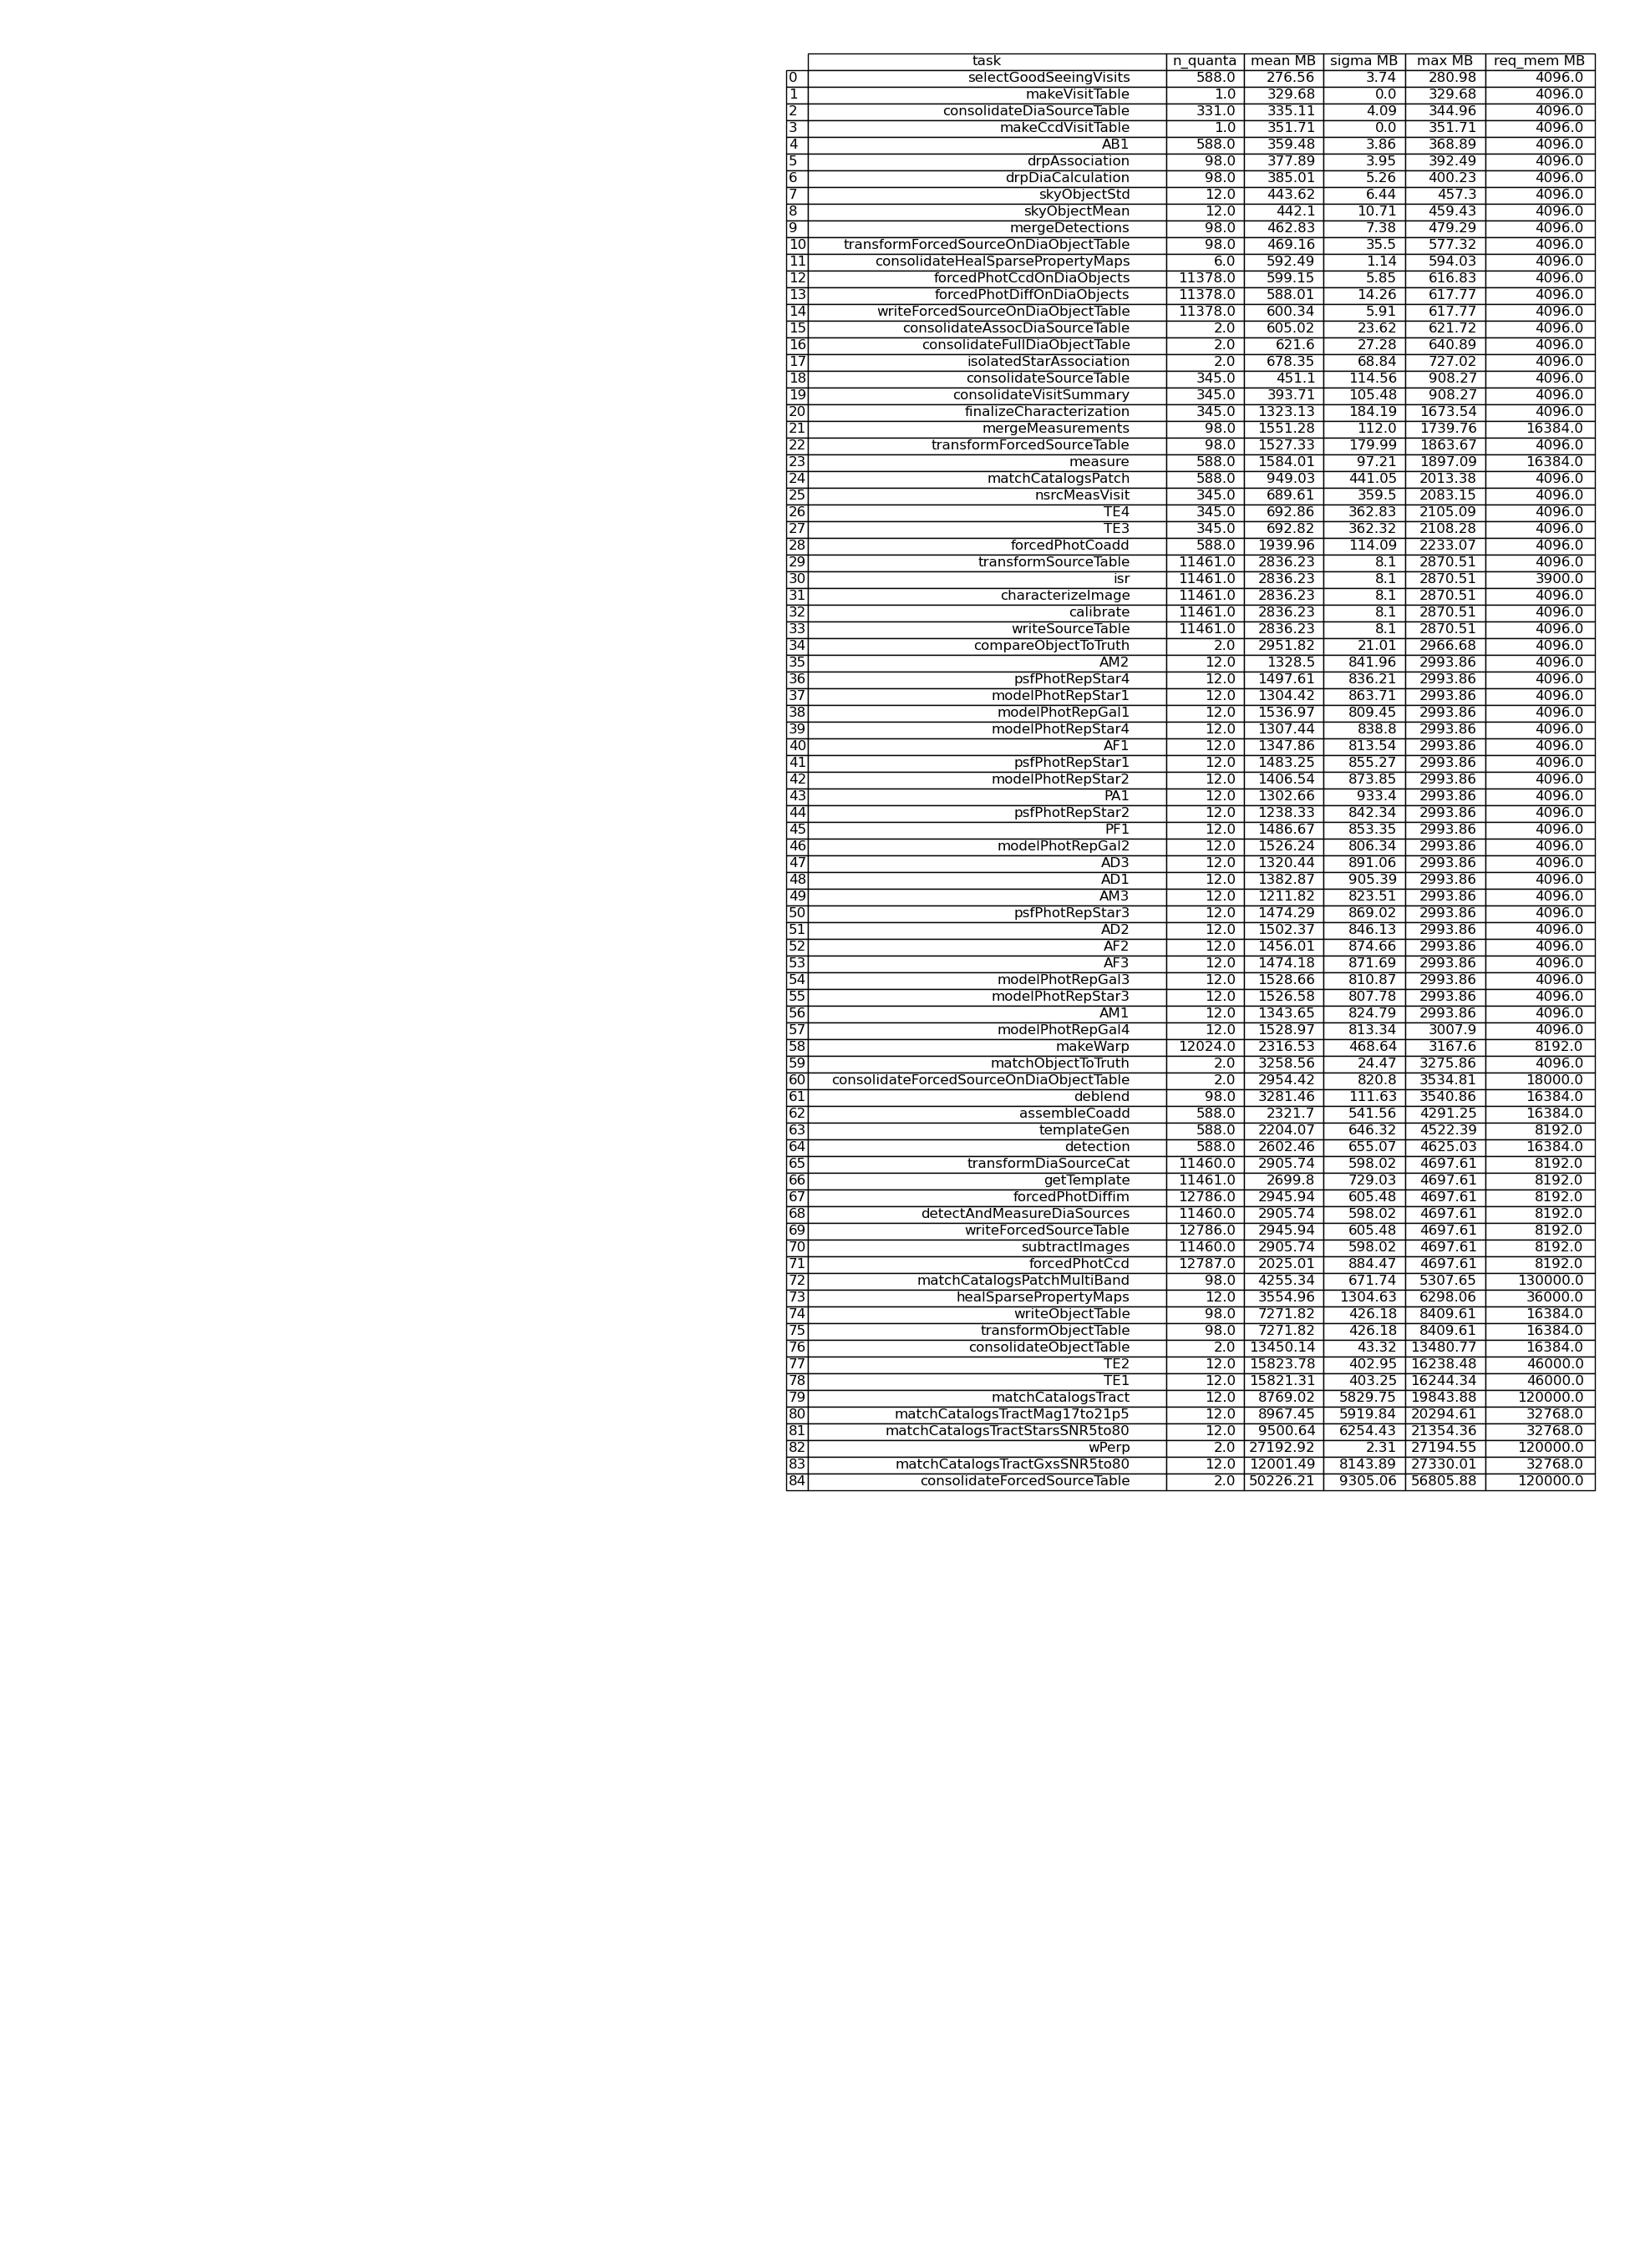

╒════╤═════════════════════════════════════════╤════════════╤═══════════╤════════════╤══════════╤══════════════╕
│    │ task                                    │   n_quanta │   mean MB │   sigma MB │   max MB │   req_mem MB │
╞════╪═════════════════════════════════════════╪════════════╪═══════════╪════════════╪══════════╪══════════════╡
│  0 │ selectGoodSeeingVisits                  │        588 │    276.56 │       3.74 │   280.98 │         4096 │
├────┼─────────────────────────────────────────┼────────────┼───────────┼────────────┼──────────┼──────────────┤
│  1 │ makeVisitTable                          │          1 │    329.68 │       0    │   329.68 │         4096 │
├────┼─────────────────────────────────────────┼────────────┼───────────┼────────────┼──────────┼──────────────┤
│  2 │ consolidateDiaSourceTable               │        331 │    335.11 │       4.09 │   344.96 │         4096 │
├────┼─────────────────────────────────────────┼────────────┼───────────┼────────────┼──────────

In [37]:
if __name__ == '__main__':
    name='/home/k/kuropatk/u/prod/memory.yaml'
    memory_data(name)